# Homework 06 Till Meineke

> Note: sometimes your answer doesn't match one of the options exactly. That's fine. Select the option that's closest to your solution.

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

## Dataset

In this homework, we will use the Students Performance in 2024 JAMB dataset from [Kaggle](https://www.kaggle.com/datasets/idowuadamo/students-performance-in-2024-jamb).

Here's a wget-able [link](https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv):

```bash
wget https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv
```

The goal of this homework is to create a regression model for predicting the performance of students on a standardized test (column `'JAMB_Score'`).

This dataset was generated using statistics from the 2024 Joint Admissions and Matriculation Board (JAMB) examination to predict students performance. JAMB is a standardized test for university admissions in Nigeria. It aims to identify factors affecting student performance and support the development of targeted interventions to improve outcomes.

In [3]:
df = pd.read_csv(
    "https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv"
)
df.head().T

,0,1,2,3,4
JAMB_Score,192,207,182,210,199
Study_Hours_Per_Week,22,14,29,29,12
Attendance_Rate,78,88,87,99,98
Teacher_Quality,4,4,2,2,3
Distance_To_School,12.4,2.7,9.6,2.6,8.8
School_Type,Public,Public,Public,Public,Public
School_Location,Urban,Rural,Rural,Urban,Urban
Extra_Tutorials,Yes,No,Yes,No,No
Access_To_Learning_Materials,Yes,Yes,Yes,Yes,Yes
Parent_Involvement,High,High,High,Medium,Medium


## Preparing the dataset

First, let's make the names lowercase:

```python
df.columns = df.columns.str.lower().str.replace(' ', '_')
```

In [4]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

Preparation:

* Remove the `student_id` column.

In [5]:
df = df.drop(columns="student_id")

* Fill missing values with zeros.

In [6]:
df = df.fillna(0)

* Do train/validation/test split with 60%/20%/20% distribution.
* Use the `train_test_split` function and set the `random_state` parameter to 1.

In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [8]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.jamb_score.values
y_val = df_val.jamb_score.values
y_test = df_test.jamb_score.values

del df_train["jamb_score"]
del df_val["jamb_score"]
del df_test["jamb_score"]

In [9]:
train_dicts = df_train.to_dict(orient="records")
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient="records")
X_val = dv.transform(val_dicts)

In [10]:
test_dicts = df_test.to_dict(orient="records")
X_test = dv.transform(test_dicts)

## Question 1

Let's train a decision tree regressor to predict the `jamb_score` variable.

* Train a model with `max_depth=1`.

In [11]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [12]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [13]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



Which feature is used for splitting the data?

* **`study_hours_per_week`**
* ~~`attendance_rate`~~
* ~~`teacher_quality`~~
* ~~`distance_to_school`~~

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

In [15]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

What's the RMSE of this model on validation?

* ~~22.13~~
* **42.13**
* ~~62.13~~
* ~~82.12~~

In [16]:
y_pred = rf.predict(X_val)
root_mean_squared_error(y_val, y_pred)

42.13724207871227

## Question 3

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

%matplotlib inline

/opt/homebrew/Caskroom/miniforge/base/envs/ML_Zoomcamp2024/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.

In [18]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    score = root_mean_squared_error(y_val, y_pred)

    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=["n_estimators", "rmse"])

100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


In [19]:
df_scores

,n_estimators,rmse
0,10,42.137242
1,20,41.461215
2,30,41.106171
3,40,40.917194
4,50,40.852279
5,60,40.784281
6,70,40.677098
7,80,40.539333
8,90,40.504346
9,100,40.516805


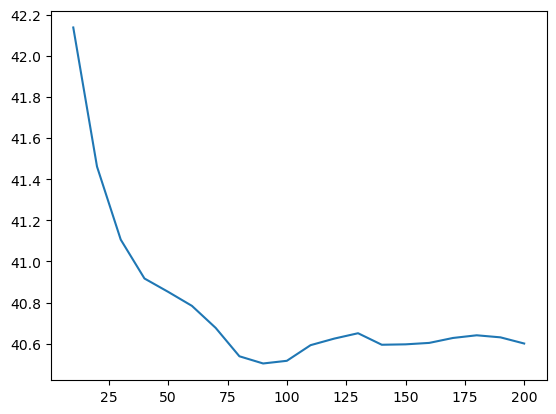

In [31]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

plt.show();

After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for calculating the answer.

* ~~10~~
* ~~25~~
* **80**
* ~~200~~

We can use `warm_start=True` to train faster. In this case, we train only additional 10 new trees each time, not the entire ensemble from scratch like previously

```plaintext
warm_start : bool, default=False
    When set to ``True``, reuse the solution of the previous call to fit
    and add more estimators to the ensemble, otherwise, just fit a whole
    new forest. See :term:`the Glossary <warm_start>`.
```

In [26]:
scores = []

rf = RandomForestRegressor(
    n_estimators=1,
    random_state=1,
    n_jobs=-1,
    warm_start=True,
)

for n in tqdm(range(10, 201, 10)):
    rf.n_estimators = n
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    score = root_mean_squared_error(y_val, y_pred)

    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=["n_estimators", "rmse"])

100%|██████████| 20/20 [00:03<00:00,  5.58it/s]


It's 3 seconds instead of 27 seconds now (on MacBookPro 13" M1 16GB).

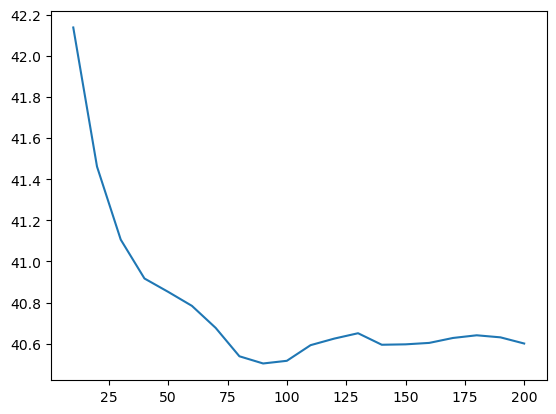

In [27]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))
plt.show()

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE
* Fix the random seed: `random_state=1`

In [32]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(
        n_estimators=0, max_depth=d, random_state=1, n_jobs=-1, warm_start=True
    )

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = root_mean_squared_error(y_val, y_pred)

        scores.append((d, n, score))

columns = ["max_depth", "n_estimators", "rmse"]
df_scores = pd.DataFrame(scores, columns=columns)

100%|██████████| 4/4 [00:11<00:00,  2.98s/it]


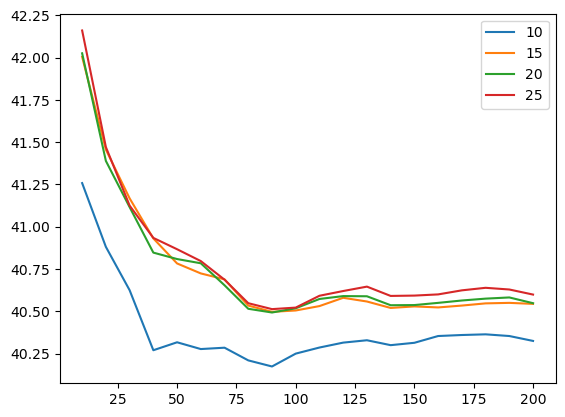

In [34]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse.round(3), label=d)

plt.legend()
plt.show();

What's the best `max_depth`, using the mean RMSE?

* **10**
* ~~15~~
* ~~20~~
* ~~25~~

## Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split.
When doing it, we can calculate "gain" - the reduction in impurity before and after the split.
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field.

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)

In [35]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

* Get the feature importance information from this model

In [36]:
df_importances = pd.DataFrame()
df_importances["feature"] = dv.feature_names_
df_importances["importance"] = rf.feature_importances_
df_importances.sort_values(by="importance", ascending=False).head()

,feature,importance
27,study_hours_per_week,0.248354
4,attendance_rate,0.149729
5,distance_to_school,0.136486
28,teacher_quality,0.082682
2,age,0.069311


In [46]:
most_important = df_importances.sort_values(by="importance", ascending=False).head(1).values[0][0]

print(f"The most important feature (among these 4) is: {most_important})")

The most important feature (among these 4) is: study_hours_per_week)


What's the most important feature (among these 4)?

* **`study_hours_per_week`**
* ~~`attendance_rate`~~
* ~~`distance_to_school`~~
* ~~`teacher_quality`~~

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost

In [47]:
import xgboost as xgb

* Create DMatrix for train and validation

In [49]:
features = dv.feature_names_
features

['access_to_learning_materials=No',
 'access_to_learning_materials=Yes',
 'age',
 'assignments_completed',
 'attendance_rate',
 'distance_to_school',
 'extra_tutorials=No',
 'extra_tutorials=Yes',
 'gender=Female',
 'gender=Male',
 'it_knowledge=High',
 'it_knowledge=Low',
 'it_knowledge=Medium',
 'parent_education_level',
 'parent_education_level=Primary',
 'parent_education_level=Secondary',
 'parent_education_level=Tertiary',
 'parent_involvement=High',
 'parent_involvement=Low',
 'parent_involvement=Medium',
 'school_location=Rural',
 'school_location=Urban',
 'school_type=Private',
 'school_type=Public',
 'socioeconomic_status=High',
 'socioeconomic_status=Low',
 'socioeconomic_status=Medium',
 'study_hours_per_week',
 'teacher_quality']

In [50]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

* Create a watchlist

In [51]:
watchlist = [(dtrain, "train"), (dval, "val")]
scores = {}

In [52]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split("\n"):
        it_line, train_line, val_line = line.split("\t")

        it = int(it_line.strip("[]"))
        train = float(train_line.split(":")[1])
        val = float(val_line.split(":")[1])

        results.append((it, train, val))

    columns = ["num_iter", "train_auc", "val_auc"]
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

* Train a model with these parameters for 100 rounds:

```python
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
```

In [53]:
%%capture output_03

xgb_params = {
    "eta": 0.3,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "reg:squarederror",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}

model = xgb.train(
    xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist
)

In [54]:
scores["eta=0.3"] = parse_xgb_output(output_03)

Now change `eta` from `0.3` to `0.1`.

In [55]:
%%capture output_01

xgb_params = {
    "eta": 0.1,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "reg:squarederror",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}

model = xgb.train(
    xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist
)

In [56]:
scores["eta=0.1"] = parse_xgb_output(output_01)

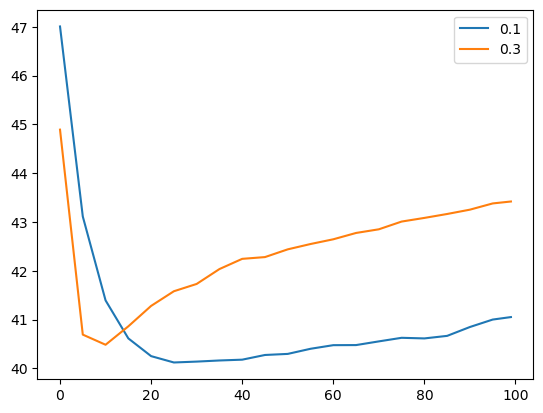

In [57]:
plt.plot(scores["eta=0.1"].num_iter, scores["eta=0.1"].val_auc, label="0.1")
plt.plot(scores["eta=0.3"].num_iter, scores["eta=0.3"].val_auc, label="0.3")
plt.legend()
plt.show();

Which eta leads to the best RMSE score on the validation dataset?

* ~~0.3~~
* **0.1**
* ~~Both give equal value~~

## Homework URL


[Homework](https://github.com/TillMeineke/ML_Zoomcamp2024_hw/blob/main/06-trees/homework_06_till_meineke.ipynb)

## Learning in public links (optional)

- [x] Learn in public 1: leaderboard week5 [LinkedIn](https://www.linkedin.com/posts/tillmeineke_mlzoomcamp-activity-7259182992189771776-MeC2?utm_source=share&utm_medium=member_desktop) on 4 November 2024
- [x] Learn in public 2: weekly learning [LinkedIn](https://www.linkedin.com/posts/tillmeineke_mlzoomcamp-activity-7259186203562807296-3DRM?utm_source=share&utm_medium=member_desktop) on 4 November 2024
- [x] Learn in public 3: Decision Tree [LinkedIn](https://www.linkedin.com/posts/tillmeineke_mlzoomcamp-activity-7259259395312652288-Xjou/?utm_source=share&utm_medium=member_desktop) on 4 November 2024
- [x] Learn in public 4: Decision Tree Parameter Tuning [LinkedIn](https://www.linkedin.com/posts/tillmeineke_mlzoomcamp-activity-7259285029564940288-nhlC?utm_source=share&utm_medium=member_desktop) on 4 November 2024
- [x] Learn in public 5: Random Forests [LinkedIn](https://www.linkedin.com/posts/tillmeineke_mlzoomcamp-activity-7259296186312916993-mLnd?utm_source=share&utm_medium=member_desktop) on 4 November 2024
- [x] Learn in public 6: Boosting [LinkedIn](https://www.linkedin.com/posts/tillmeineke_mlzoomcamp-activity-7259300465681547264-4PUe?utm_source=share&utm_medium=member_desktop) on 4 November 2024
- [x] Learn in public 7: Wrapping up week 6 [LinkedIn](https://www.linkedin.com/posts/tillmeineke_mlzoomcamp-activity-7259335214248706049-Lsqj?utm_source=share&utm_medium=member_desktop) on 4 November 2024

## Time spent on lectures (hours) (optional)

## Time spent on homework (hours) (optional)

## FAQ contribution (FAQ document, optional)

Link to homework 6 added.